In [84]:
import pandas as pds
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import sklearn.inspection as skli
import seaborn as sns

In [85]:
# Read and join tables
dir = os.getcwd()

leaderboards = pds.read_csv(os.path.join(os.getcwd(),"data\\v1\\leaderboards-data.csv"), parse_dates=['date', 'verifiedDate'])
games = pds.read_csv(os.path.join(os.getcwd(),"data\\v1\\games-data.csv"), parse_dates=['releaseDate', 'createdDate'])
users = pds.read_csv(os.path.join(os.getcwd(),"data\\v1\\users-data.csv"), parse_dates=['signupDate'])
categories = pds.read_csv(os.path.join(os.getcwd(),"data\\v1\\categories-data.csv"))

data_frame = leaderboards.merge(games, left_on="gameID", right_on="ID", how="left", suffixes=('_df1', '_gme'))
data_frame = data_frame.merge(users, left_on="players", right_on="ID", how="left", suffixes=('_df2', '_usr'))
data_frame = data_frame.merge(categories, left_on="categoryID", right_on="ID", how="left", suffixes=('_df3', '_cat'))

data_frame = data_frame.drop(columns=['ID_df2', 'name_df2', 'URL', 'name_usr', 'parentGameID', 'ID_usr', 'name', 'rules', 'variablesAndValues', 'ID'])
 
display(data_frame)
# Split players rows where there are multiple players into multiple rows 
cols = list(data_frame.columns.drop('players' ))
data_frame = (data_frame
   .set_index(cols)
   .stack()
   .str.split(',', expand=True)
   .stack()
   .unstack(-2)
   .reset_index(-1, drop=True)
   .reset_index()
)

for col in data_frame.columns[data_frame.dtypes == 'object']:
    data_frame[col] = data_frame[col].astype('category')

,runID,gameID,categoryID,levelID,date,primaryTime,place,platform,emulated,players,examiner,verifiedDate,releaseDate,createdDate,numCategories,numLevels,signupDate,location,numRuns,type,numPlayers
0,zpg4gdnz,j1n8nj91,8249gled,NaN,2022-12-20,108.000,1,vm9vn63k,True,8d4kdg58,0jm4ppnj,2022-12-21 09:32:39+00:00,1971-11-01,2022-10-11 15:53:28+00:00,3,0,2021-11-08 20:34:20+00:00,us,36.0,per-game,1
1,y9xp7kny,j1n8nj91,8249gled,NaN,2022-10-08,114.067,2,vm9vn63k,True,0jm4ppnj,0jm4ppnj,2022-10-11 19:00:28+00:00,1971-11-01,2022-10-11 15:53:28+00:00,3,0,2018-06-05 14:39:39+00:00,NaN,204.0,per-game,1
2,m3q7po4y,ldejl7j1,w20m70zk,NaN,2023-06-18,434.000,1,NaN,True,xk1lp76j,j204y17x,2023-07-08 15:55:58+00:00,1975-01-01,2023-05-24 18:46:03+00:00,1,0,2023-05-20 22:30:30+00:00,us,22.0,per-game,1
3,ywr8xv2m,ldejl7j1,w20m70zk,NaN,2023-05-24,610.000,2,NaN,True,j204y17x,j204y17x,2023-05-24 19:22:27+00:00,1975-01-01,2023-05-24 18:46:03+00:00,1,0,2023-05-17 04:56:49+00:00,us,1.0,per-game,1
4,zq91ko8y,9d389y91,vdopjgy2,NaN,2022-08-19,25.000,1,v06ddw64,False,8vk4w7vj,8vk4w7vj,2022-08-23 07:09:21+00:00,1976-01-01,2022-08-23 03:09:59+00:00,1,0,2021-04-27 03:29:39+00:00,jp,109.0,per-game,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847575,mee42eqm,268wwry6,wkpgwqvk,NaN,2023-01-22,1661.626,21,8gej2n93,False,"866ol9p8,0jm94yn8",8wknpmq8,2023-02-01 14:33:55+00:00,2023-11-07,2021-06-26 20:35:23+00:00,2,0,NaT,NaN,NaN,per-game,2
1847576,zxlwq9gz,268wwry6,wkpgwqvk,NaN,2021-10-21,1793.943,22,8gej2n93,False,"j0vmykwx,j421715x",8wknpmq8,2022-02-09 15:52:17+00:00,2023-11-07,2021-06-26 20:35:23+00:00,2,0,NaT,NaN,NaN,per-game,2
1847577,y2xn6ljm,268wwry6,wkpgwqvk,NaN,2021-06-24,1913.647,23,8gej2n93,False,"8gezg1rj,j2wod3nj",8wknpmq8,2022-02-10 12:41:33+00:00,2023-11-07,2021-06-26 20:35:23+00:00,2,0,NaT,NaN,NaN,per-game,2
1847578,y2j76x5z,268wwry6,wkpgwqvk,NaN,2023-01-21,2126.666,24,8gej2n93,False,"j5qkwg6j,",8wknpmq8,2023-02-01 14:36:53+00:00,2023-11-07,2021-06-26 20:35:23+00:00,2,0,NaT,NaN,NaN,per-game,2


In [86]:
# Print Table

pds.set_option('display.max_columns', None)
display(data_frame)
print(data_frame.dtypes)

,runID,gameID,categoryID,levelID,date,primaryTime,place,platform,emulated,examiner,verifiedDate,releaseDate,createdDate,numCategories,numLevels,signupDate,location,numRuns,type,numPlayers,players
0,zpg4gdnz,j1n8nj91,8249gled,NaN,2022-12-20,108.000,1,vm9vn63k,True,0jm4ppnj,2022-12-21 09:32:39+00:00,1971-11-01,2022-10-11 15:53:28+00:00,3,0,2021-11-08 20:34:20+00:00,us,36.0,per-game,1,8d4kdg58
1,y9xp7kny,j1n8nj91,8249gled,NaN,2022-10-08,114.067,2,vm9vn63k,True,0jm4ppnj,2022-10-11 19:00:28+00:00,1971-11-01,2022-10-11 15:53:28+00:00,3,0,2018-06-05 14:39:39+00:00,NaN,204.0,per-game,1,0jm4ppnj
2,m3q7po4y,ldejl7j1,w20m70zk,NaN,2023-06-18,434.000,1,NaN,True,j204y17x,2023-07-08 15:55:58+00:00,1975-01-01,2023-05-24 18:46:03+00:00,1,0,2023-05-20 22:30:30+00:00,us,22.0,per-game,1,xk1lp76j
3,ywr8xv2m,ldejl7j1,w20m70zk,NaN,2023-05-24,610.000,2,NaN,True,j204y17x,2023-05-24 19:22:27+00:00,1975-01-01,2023-05-24 18:46:03+00:00,1,0,2023-05-17 04:56:49+00:00,us,1.0,per-game,1,j204y17x
4,zq91ko8y,9d389y91,vdopjgy2,NaN,2022-08-19,25.000,1,v06ddw64,False,8vk4w7vj,2022-08-23 07:09:21+00:00,1976-01-01,2022-08-23 03:09:59+00:00,1,0,2021-04-27 03:29:39+00:00,jp,109.0,per-game,1,8vk4w7vj
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909098,y2xn6ljm,268wwry6,wkpgwqvk,NaN,2021-06-24,1913.647,23,8gej2n93,False,8wknpmq8,2022-02-10 12:41:33+00:00,2023-11-07,2021-06-26 20:35:23+00:00,2,0,NaT,NaN,NaN,per-game,2,j2wod3nj
1909099,y2j76x5z,268wwry6,wkpgwqvk,NaN,2023-01-21,2126.666,24,8gej2n93,False,8wknpmq8,2023-02-01 14:36:53+00:00,2023-11-07,2021-06-26 20:35:23+00:00,2,0,NaT,NaN,NaN,per-game,2,j5qkwg6j
1909100,y2j76x5z,268wwry6,wkpgwqvk,NaN,2023-01-21,2126.666,24,8gej2n93,False,8wknpmq8,2023-02-01 14:36:53+00:00,2023-11-07,2021-06-26 20:35:23+00:00,2,0,NaT,NaN,NaN,per-game,2,
1909101,zgqjkrjy,268wwry6,wkpgwqvk,NaN,2022-10-11,2669.045,25,8gej2n93,False,8wknpmq8,2022-10-18 21:21:18+00:00,2023-11-07,2021-06-26 20:35:23+00:00,2,0,NaT,NaN,NaN,per-game,2,8ge4y2yj


runID                       category
gameID                      category
categoryID                  category
levelID                     category
date                  datetime64[ns]
primaryTime                  float64
place                          int64
platform                    category
emulated                        bool
examiner                    category
verifiedDate     datetime64[ns, UTC]
releaseDate           datetime64[ns]
createdDate      datetime64[ns, UTC]
numCategories                  int64
numLevels                      int64
signupDate       datetime64[ns, UTC]
location                    category
numRuns                      float64
type                        category
numPlayers                     int64
players                     category
dtype: object


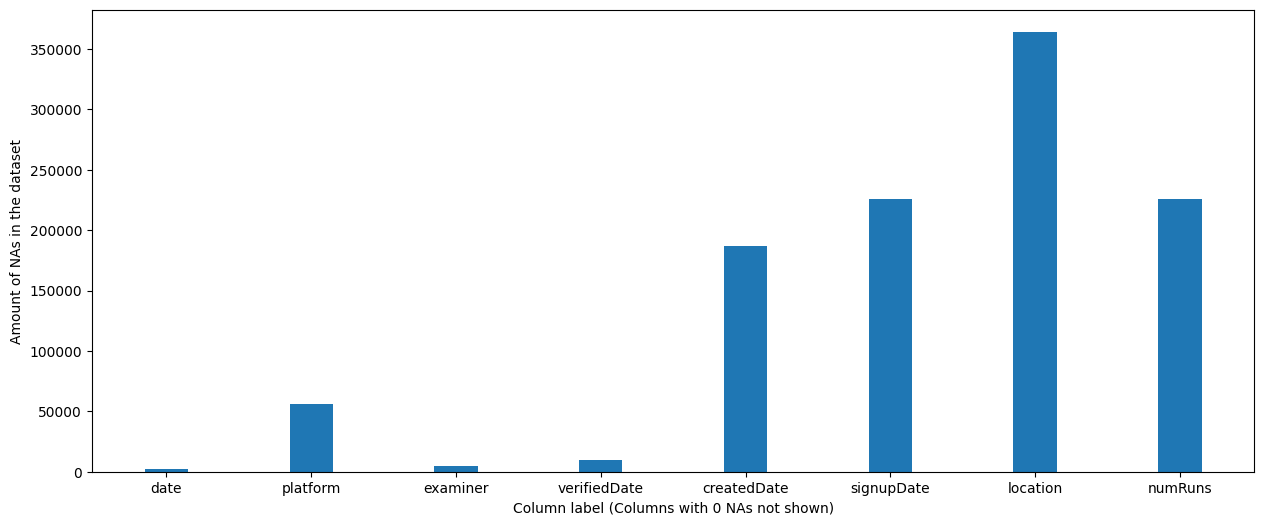

,runID,gameID,categoryID,levelID,date,primaryTime,place,platform,emulated,examiner,verifiedDate,releaseDate,createdDate,numCategories,numLevels,signupDate,location,numRuns,type,numPlayers,players
0,1607367,13979,18905,20077,1.671494e+09,108.000,1,161,True,115,1.671615e+09,57801600,1.665504e+09,3,0,1.636404e+09,239,36.00000,0,1,59417
1,807451,13979,18905,20077,1.665187e+09,114.067,2,161,True,115,1.665515e+09,57801600,1.665504e+09,3,0,1.528210e+09,239,204.00000,0,1,557
2,115939,19567,70218,20077,1.687046e+09,434.000,1,44,True,15197,1.688832e+09,157766400,1.684954e+09,1,0,1.684622e+09,239,22.00000,0,1,340391
3,1203563,19567,70218,20077,1.684886e+09,610.000,2,44,True,15197,1.684956e+09,157766400,1.684954e+09,1,0,1.684299e+09,239,1.00000,0,1,179902
4,1663381,9363,66635,20077,1.660867e+09,25.000,1,151,False,11455,1.661239e+09,189302400,1.661224e+09,1,0,1.619494e+09,122,109.00000,0,1,139352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909098,503506,1640,83345,20077,1.624493e+09,1913.647,23,44,False,11994,1.644497e+09,1699315200,1.624740e+09,2,0,1.569096e+09,239,510.22873,0,2,188061
1909099,473217,1640,83345,20077,1.674259e+09,2126.666,24,44,False,11994,1.675262e+09,1699315200,1.624740e+09,2,0,1.569096e+09,239,510.22873,0,2,209684
1909100,473217,1640,83345,20077,1.674259e+09,2126.666,24,44,False,11994,1.675262e+09,1699315200,1.624740e+09,2,0,1.569096e+09,239,510.22873,0,2,0
1909101,1478192,1640,83345,20077,1.665446e+09,2669.045,25,44,False,11994,1.666128e+09,1699315200,1.624740e+09,2,0,1.569096e+09,239,510.22873,0,2,84829


runID              int32
gameID             int32
categoryID         int32
levelID            int32
date             float64
primaryTime      float64
place              int64
platform           int16
emulated            bool
examiner           int32
verifiedDate     float64
releaseDate        int64
createdDate      float64
numCategories      int64
numLevels          int64
signupDate       float64
location           int16
numRuns          float64
type                int8
numPlayers         int64
players            int32
dtype: object


In [87]:
# Preprocessing

def replaceNaNsWithMostFrequent(value):
    return value.fillna(value.mode()[0])

def replaceNaNsWithMean(value):
    return value.fillna(value.mean())

def mapValuesToIntegers(value):
    return value.cat.codes

def convertToUNIXTimestamp(date):
    return (date.fillna("1970-01-01").astype('int64') // (10**9)).replace(0, np.NaN)

vals = data_frame.drop(columns=['runID', 'levelID', 'emulated']).isnull().sum()
cols = data_frame.columns.drop(['runID', 'levelID', 'emulated'])[vals != 0]
vals = vals[vals != 0]
plt.figure(figsize= (15, 6))
plt.bar(cols, vals, width=0.3)
plt.ylabel("Amount of NAs in the dataset")
plt.xlabel("Column label (Columns with 0 NAs not shown)")
plt.show()

data_frame[['date', 
            'verifiedDate', 
            'releaseDate', 
            'createdDate', 
            'signupDate']] = data_frame[['date', 
                                         'verifiedDate', 
                                         'releaseDate', 
                                         'createdDate', 
                                         'signupDate']].apply(convertToUNIXTimestamp)
data_frame[['date', 
            'verifiedDate', 
            'releaseDate', 
            'createdDate', 
            'signupDate',
            'numRuns']] = data_frame[['date', 
                                         'verifiedDate', 
                                         'releaseDate', 
                                         'createdDate', 
                                         'signupDate',
                                         'numRuns']].apply(replaceNaNsWithMean)

for col in data_frame.columns[data_frame.dtypes == 'category']:
    data_frame[[col]] = data_frame[[col]].apply(replaceNaNsWithMostFrequent)
    data_frame[[col]] = data_frame[[col]].apply(mapValuesToIntegers)

display(data_frame)
print(data_frame.dtypes)

In [88]:
# Normalization

minmax = data_frame.copy(deep=True)

for col in data_frame.columns[data_frame.dtypes != 'bool']:
    minimum = data_frame[col].min()
    minmax[col] = (data_frame[col] - minimum) / (data_frame[col].max() - minimum)

display(data_frame)
print(data_frame.isnull().sum())
display(minmax)
print(minmax.isnull().sum())

,runID,gameID,categoryID,levelID,date,primaryTime,place,platform,emulated,examiner,verifiedDate,releaseDate,createdDate,numCategories,numLevels,signupDate,location,numRuns,type,numPlayers,players
0,1607367,13979,18905,20077,1.671494e+09,108.000,1,161,True,115,1.671615e+09,57801600,1.665504e+09,3,0,1.636404e+09,239,36.00000,0,1,59417
1,807451,13979,18905,20077,1.665187e+09,114.067,2,161,True,115,1.665515e+09,57801600,1.665504e+09,3,0,1.528210e+09,239,204.00000,0,1,557
2,115939,19567,70218,20077,1.687046e+09,434.000,1,44,True,15197,1.688832e+09,157766400,1.684954e+09,1,0,1.684622e+09,239,22.00000,0,1,340391
3,1203563,19567,70218,20077,1.684886e+09,610.000,2,44,True,15197,1.684956e+09,157766400,1.684954e+09,1,0,1.684299e+09,239,1.00000,0,1,179902
4,1663381,9363,66635,20077,1.660867e+09,25.000,1,151,False,11455,1.661239e+09,189302400,1.661224e+09,1,0,1.619494e+09,122,109.00000,0,1,139352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909098,503506,1640,83345,20077,1.624493e+09,1913.647,23,44,False,11994,1.644497e+09,1699315200,1.624740e+09,2,0,1.569096e+09,239,510.22873,0,2,188061
1909099,473217,1640,83345,20077,1.674259e+09,2126.666,24,44,False,11994,1.675262e+09,1699315200,1.624740e+09,2,0,1.569096e+09,239,510.22873,0,2,209684
1909100,473217,1640,83345,20077,1.674259e+09,2126.666,24,44,False,11994,1.675262e+09,1699315200,1.624740e+09,2,0,1.569096e+09,239,510.22873,0,2,0
1909101,1478192,1640,83345,20077,1.665446e+09,2669.045,25,44,False,11994,1.666128e+09,1699315200,1.624740e+09,2,0,1.569096e+09,239,510.22873,0,2,84829


runID            0
gameID           0
categoryID       0
levelID          0
date             0
primaryTime      0
place            0
platform         0
emulated         0
examiner         0
verifiedDate     0
releaseDate      0
createdDate      0
numCategories    0
numLevels        0
signupDate       0
location         0
numRuns          0
type             0
numPlayers       0
players          0
dtype: int64


,runID,gameID,categoryID,levelID,date,primaryTime,place,platform,emulated,examiner,verifiedDate,releaseDate,createdDate,numCategories,numLevels,signupDate,location,numRuns,type,numPlayers,players
0,0.908241,0.386128,0.171887,0.134506,0.982634,0.000030,0.000164,0.884615,True,0.003438,0.895609,0.000000,0.881013,0.010811,0.0,0.797511,0.929961,0.003600,0.0,0.000000,0.152579
1,0.456249,0.386128,0.171887,0.134506,0.978781,0.000032,0.000327,0.884615,True,0.003438,0.873229,0.000000,0.881013,0.010811,0.0,0.452109,0.929961,0.020400,0.0,0.000000,0.001430
2,0.065511,0.540480,0.638433,0.134506,0.992135,0.000121,0.000164,0.241758,True,0.454374,0.958770,0.060898,0.950076,0.000000,0.0,0.951444,0.929961,0.002200,0.0,0.000000,0.874102
3,0.680072,0.540480,0.638433,0.134506,0.990816,0.000169,0.000327,0.241758,True,0.454374,0.944552,0.060898,0.950076,0.000000,0.0,0.950414,0.929961,0.000100,0.0,0.000000,0.461977
4,0.939892,0.258625,0.605855,0.134506,0.976141,0.000007,0.000164,0.829670,False,0.342492,0.857541,0.080109,0.865819,0.000000,0.0,0.743528,0.474708,0.010900,0.0,0.000000,0.357847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909098,0.284506,0.045300,0.757785,0.134506,0.953919,0.000532,0.003761,0.241758,False,0.358608,0.796122,1.000000,0.736273,0.005405,0.0,0.582634,0.929961,0.051023,0.0,0.052632,0.482928
1909099,0.267391,0.045300,0.757785,0.134506,0.984323,0.000591,0.003924,0.241758,False,0.358608,0.908988,1.000000,0.736273,0.005405,0.0,0.582634,0.929961,0.051023,0.0,0.052632,0.538455
1909100,0.267391,0.045300,0.757785,0.134506,0.984323,0.000591,0.003924,0.241758,False,0.358608,0.908988,1.000000,0.736273,0.005405,0.0,0.582634,0.929961,0.051023,0.0,0.052632,0.000000
1909101,0.835251,0.045300,0.757785,0.134506,0.978939,0.000741,0.004088,0.241758,False,0.358608,0.875479,1.000000,0.736273,0.005405,0.0,0.582634,0.929961,0.051023,0.0,0.052632,0.217835


runID            0
gameID           0
categoryID       0
levelID          0
date             0
primaryTime      0
place            0
platform         0
emulated         0
examiner         0
verifiedDate     0
releaseDate      0
createdDate      0
numCategories    0
numLevels        0
signupDate       0
location         0
numRuns          0
type             0
numPlayers       0
players          0
dtype: int64


(array([False,  True]), array([169062, 169062], dtype=int64))


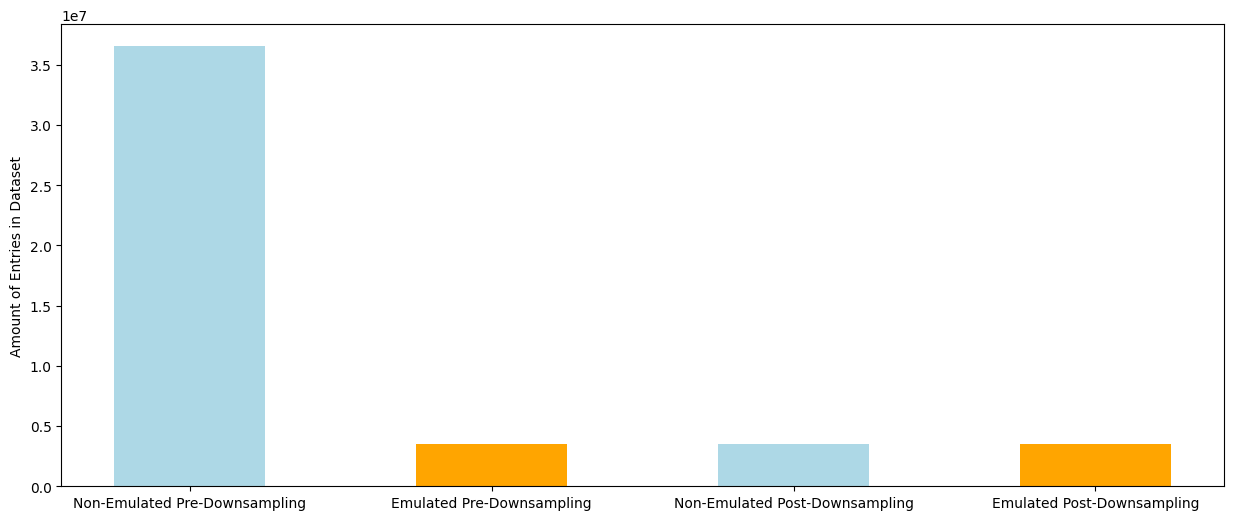

,gameID,categoryID,date,primaryTime,place,platform,examiner,verifiedDate,releaseDate,createdDate,numCategories,numLevels,signupDate,location,numRuns,type,numPlayers,players
1514401,0.395354,0.744356,0.956506,0.000261,0.000164,0.197802,0.656670,0.738645,0.918048,0.535970,0.005405,0.000000,0.460181,0.642023,0.0068,0.0,0.0,0.068299
72466,0.154932,0.000782,0.941779,0.000010,0.000164,0.527473,0.723435,0.649972,0.406969,0.595854,0.032432,0.049116,0.484550,0.143969,0.0390,1.0,0.0,0.758208
424242,0.355081,0.116707,0.961467,0.000038,0.000164,0.087912,0.648149,0.768160,0.660666,0.711202,0.097297,0.015717,0.336916,0.929961,0.0050,1.0,0.0,0.727627
41945,0.135541,0.572533,0.937714,0.000009,0.001145,0.401099,0.786611,0.625787,0.360177,0.003157,0.027027,0.010314,0.431271,0.929961,0.0017,1.0,0.0,0.734060
1374309,0.787725,0.462590,0.900765,0.000104,0.000818,0.241758,0.104377,0.406629,0.897731,0.406260,0.037838,0.005403,0.254805,0.929961,0.0056,1.0,0.0,0.427004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030193,0.766373,0.384652,0.874584,0.002826,0.000491,0.197802,0.695599,0.246569,0.846676,0.171872,0.064865,0.003929,0.146317,0.929961,0.0215,0.0,0.0,0.747233
784014,0.769909,0.399718,0.932225,0.000006,0.049052,0.241758,0.102494,0.592785,0.791463,0.097298,0.043243,0.016208,0.646116,0.696498,0.0002,1.0,0.0,0.134963
871067,0.474933,0.685375,0.869992,0.000003,0.000818,0.945055,0.986516,0.222121,0.810674,0.099798,0.016216,0.008350,0.118939,0.727626,0.0564,1.0,0.0,0.719941
432052,0.602933,0.758640,0.969913,0.000007,0.000164,0.241758,0.946361,0.818983,0.666298,0.095714,0.064865,0.019155,0.842977,0.929961,0.0019,1.0,0.0,0.384096


,gameID,categoryID,date,primaryTime,place,platform,examiner,verifiedDate,releaseDate,createdDate,numCategories,numLevels,signupDate,location,numRuns,type,numPlayers,players
194765,0.840980,0.338010,0.954605,0.000060,0.000491,0.631868,0.712671,0.728298,0.503079,0.136532,0.010811,0.000000,0.287046,0.474708,0.018500,0.0,0.000000,0.972741
331825,0.023893,0.240742,0.926630,0.000044,0.000164,0.021978,0.632094,0.559627,0.603137,0.197960,0.016216,0.004420,0.209534,0.929961,0.001800,1.0,0.000000,0.994299
1615831,0.432809,0.525881,0.962787,0.000022,0.002289,0.175824,0.316181,0.776520,0.934733,0.621255,0.059459,0.000000,0.582634,0.929961,0.051023,0.0,0.052632,0.804169
238573,0.330442,0.499604,0.857429,0.000522,0.015860,0.994505,0.780721,0.143423,0.538344,0.419313,0.037838,0.001965,0.058680,0.046693,0.001500,0.0,0.000000,0.800230
464082,0.917686,0.901532,0.954394,0.000009,0.000327,0.241758,0.946361,0.725754,0.686720,0.082112,0.108108,0.019155,0.730986,0.147860,0.002300,1.0,0.000000,0.479770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1669818,0.984145,0.861772,0.941251,0.000136,0.001635,0.478022,0.228278,0.646922,0.941681,0.661945,0.043243,0.019646,0.689010,0.428016,0.049000,0.0,0.000000,0.334073
58979,0.282932,0.420712,0.953814,0.000049,0.038751,0.197802,0.747982,0.722351,0.385547,0.419313,0.016216,0.000000,0.487780,0.311284,0.000200,0.0,0.000000,0.063777
1304314,0.749468,0.312161,0.955133,0.000900,0.000491,0.478022,0.376308,0.730163,0.885415,0.734692,0.000000,0.007367,0.765930,0.046693,0.000400,1.0,0.000000,0.106520
1143164,0.553545,0.663181,0.918448,0.001090,0.001145,0.675824,0.428751,0.509972,0.867730,0.228653,0.032432,0.000000,0.330235,0.929961,0.000900,0.0,0.000000,0.982877


1514401     True
72466       True
424242      True
41945       True
1374309    False
           ...  
1030193    False
784014     False
871067      True
432052     False
241038     False
Name: emulated, Length: 226543, dtype: bool

194765     False
331825      True
1615831    False
238573      True
464082     False
           ...  
1669818    False
58979       True
1304314     True
1143164    False
1579149    False
Name: emulated, Length: 111581, dtype: bool

In [89]:
# Test-Train Split + Downsampling
rdm_seed = 404

minmax_majority = minmax[minmax['emulated'] == False]
minmax_minority = minmax[minmax['emulated'] == True]

mm_downsampled = resample(minmax_majority, 
                                 replace=False,    
                                 n_samples=len(minmax_minority),  
                                 random_state=rdm_seed) 

minmax = pds.concat([mm_downsampled, minmax_minority])
 
# Display new class counts
print(np.unique(minmax['emulated'], return_counts=True))

target = minmax['emulated']

plt.figure(figsize= (15, 6))
plt.bar(["Non-Emulated Pre-Downsampling", "Emulated Pre-Downsampling", "Non-Emulated Post-Downsampling", "Emulated Post-Downsampling"], 
        [minmax_majority.size, minmax_minority.size, (minmax[minmax['emulated'] == False]).size, (minmax[minmax['emulated'] == True]).size],
        width=0.5, color=['lightblue', 'orange', 'lightblue', 'orange'])
plt.ylabel("Amount of Entries in Dataset")
plt.show()

minmax = minmax.drop(columns=['runID', 'levelID', 'emulated'])

minmax_train, minmax_test, mm_target_train, mm_target_test  = train_test_split(minmax, target,test_size = 0.33, random_state = rdm_seed, shuffle = True)
display(minmax_train)
display(minmax_test)
display(mm_target_train)
display(mm_target_test)

In [90]:
accuracyArr = [0, 0, 0, 0, 0, 0, 0, 0]
modelNames = ["KNN", "Multinomial NB", "RandomForest", "Logistic Regression", "Decision Tree", "AdaBoost", "Multi-Layered Perceptron", "Bagging"]

In [91]:
# KNN
k = 5
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(minmax_train, mm_target_train)
target_pred = knn.predict(minmax_test)

Accuracy of model with k = 5: 88.53478638836361%

Classification Report:
               precision    recall  f1-score   support

       False       0.90      0.87      0.88     55738
        True       0.87      0.90      0.89     55843

    accuracy                           0.89    111581
   macro avg       0.89      0.89      0.89    111581
weighted avg       0.89      0.89      0.89    111581



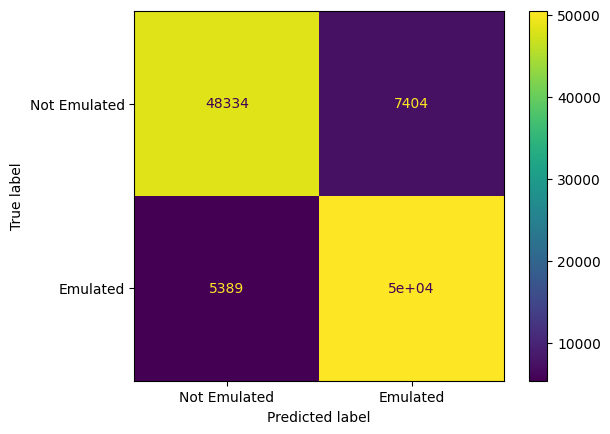

In [92]:
# KNN Post-Run Statistics

accuracy = accuracy_score(mm_target_test,target_pred) * 100
accuracyArr[0] = accuracy
conMatrix = confusion_matrix(mm_target_test, target_pred)

print(f'Accuracy of model with k = {k}: {accuracy}%\n')
print(f'Classification Report:\n {classification_report(mm_target_test, target_pred)}')
ConfusionMatrixDisplay(conMatrix, display_labels=["Not Emulated", "Emulated"],).plot()
plt.show()

In [93]:
# Multinomial Naive Bayes

MNNB = MultinomialNB()
MNNB.fit(minmax_train, mm_target_train)
target_pred = MNNB.predict(minmax_test)

Accuracy of model: 68.31270556815228%

Classification Report:
               precision    recall  f1-score   support

       False       0.69      0.66      0.67     55738
        True       0.67      0.71      0.69     55843

    accuracy                           0.68    111581
   macro avg       0.68      0.68      0.68    111581
weighted avg       0.68      0.68      0.68    111581



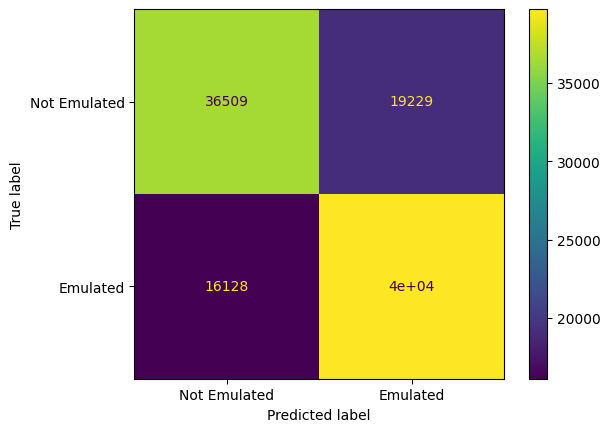

In [94]:
# Multinomial NB Post-Run Statistics

accuracy = accuracy_score(mm_target_test,target_pred) * 100
accuracyArr[1] = accuracy
conMatrix = confusion_matrix(mm_target_test, target_pred)

print(f'Accuracy of model: {accuracy}%\n')
print(f'Classification Report:\n {classification_report(mm_target_test, target_pred)}')
ConfusionMatrixDisplay(conMatrix, display_labels=["Not Emulated", "Emulated"],).plot()
plt.show()

In [95]:
# Random Forest

randomForest = RandomForestClassifier(n_estimators=200, random_state=rdm_seed, class_weight='balanced')
randomForest.fit(minmax_train,mm_target_train)
target_pred = randomForest.predict(minmax_test)

Accuracy of model: 95.54404423692205%

Classification Report:
               precision    recall  f1-score   support

       False       0.97      0.94      0.95     55738
        True       0.94      0.97      0.96     55843

    accuracy                           0.96    111581
   macro avg       0.96      0.96      0.96    111581
weighted avg       0.96      0.96      0.96    111581



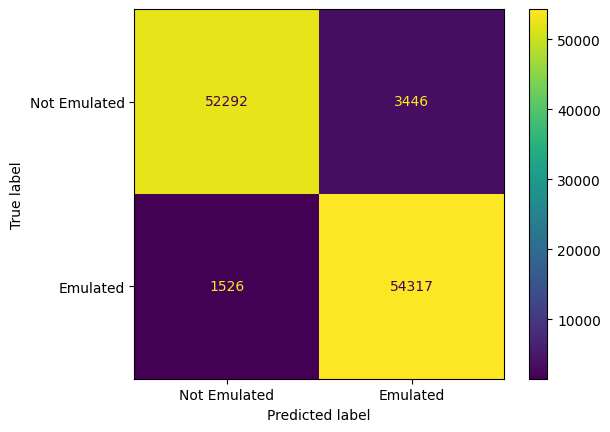

In [96]:
# Random Forest Post-Run Statistics

accuracy = accuracy_score(mm_target_test,target_pred) * 100
accuracyArr[2] = accuracy
conMatrix = confusion_matrix(mm_target_test, target_pred)

print(f'Accuracy of model: {accuracy}%\n')
print(f'Classification Report:\n {classification_report(mm_target_test, target_pred)}')
ConfusionMatrixDisplay(conMatrix, display_labels=["Not Emulated", "Emulated"],).plot()
plt.show()

In [97]:
# Logistic Regression

logReg = LogisticRegression(random_state=rdm_seed, class_weight='balanced')
logReg.fit(minmax_train, mm_target_train)
target_pred = logReg.predict(minmax_test)

Accuracy of model: 78.66841128866025%

Classification Report:
               precision    recall  f1-score   support

       False       0.77      0.81      0.79     55738
        True       0.80      0.76      0.78     55843

    accuracy                           0.79    111581
   macro avg       0.79      0.79      0.79    111581
weighted avg       0.79      0.79      0.79    111581



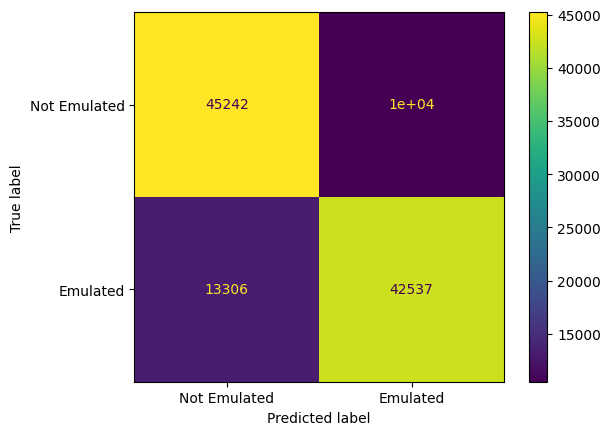

In [98]:
# Logistic Regression Post-Run Statistics

accuracy = accuracy_score(mm_target_test,target_pred) * 100
accuracyArr[3] = accuracy
conMatrix = confusion_matrix(mm_target_test, target_pred)

print(f'Accuracy of model: {accuracy}%\n')
print(f'Classification Report:\n {classification_report(mm_target_test, target_pred)}')
ConfusionMatrixDisplay(conMatrix, display_labels=["Not Emulated", "Emulated"],).plot()
plt.show()

In [99]:
# Decision Tree

dTree = DecisionTreeClassifier(random_state=rdm_seed, class_weight='balanced')
dTree.fit(minmax_train,mm_target_train)
target_pred = dTree.predict(minmax_test)

Accuracy of model: 93.09380629318612%

Classification Report:
               precision    recall  f1-score   support

       False       0.93      0.93      0.93     55738
        True       0.93      0.94      0.93     55843

    accuracy                           0.93    111581
   macro avg       0.93      0.93      0.93    111581
weighted avg       0.93      0.93      0.93    111581



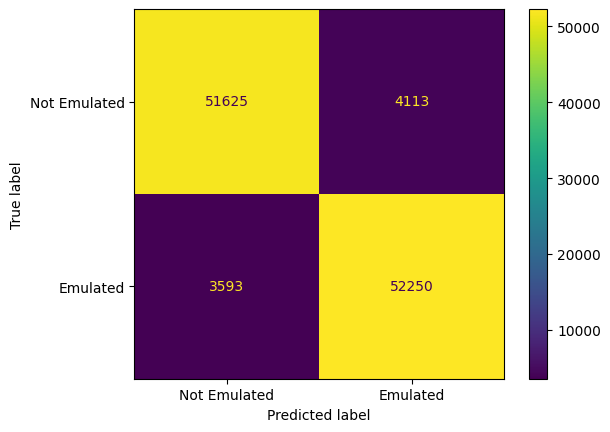

In [100]:
# Decision Tree Post-Run Statistics

accuracy = accuracy_score(mm_target_test, target_pred) * 100
accuracyArr[4] = accuracy
conMatrix = confusion_matrix(mm_target_test, target_pred)

print(f'Accuracy of model: {accuracy}%\n')
print(f'Classification Report:\n {classification_report(mm_target_test, target_pred)}')
ConfusionMatrixDisplay(conMatrix, display_labels=["Not Emulated", "Emulated"],).plot()
plt.show()

In [101]:
# AdaBoost

adaBoost = AdaBoostClassifier(algorithm='SAMME', random_state=rdm_seed)
adaBoost.fit(minmax_train,mm_target_train)
target_pred = adaBoost.predict(minmax_test)

Accuracy of model: 86.28261083876288%

Classification Report:
               precision    recall  f1-score   support

       False       0.86      0.87      0.86     55738
        True       0.87      0.85      0.86     55843

    accuracy                           0.86    111581
   macro avg       0.86      0.86      0.86    111581
weighted avg       0.86      0.86      0.86    111581



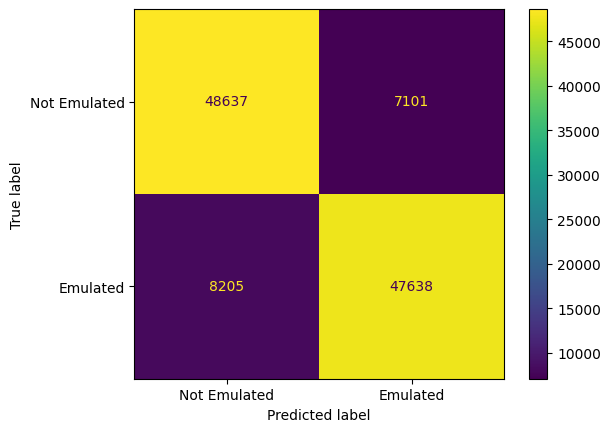

In [102]:
# AdaBoost Post-Run Statistics

accuracy = accuracy_score(mm_target_test, target_pred) * 100
accuracyArr[5] = accuracy
conMatrix = confusion_matrix(mm_target_test, target_pred)

print(f'Accuracy of model: {accuracy}%\n')
print(f'Classification Report:\n {classification_report(mm_target_test, target_pred)}')
ConfusionMatrixDisplay(conMatrix, display_labels=["Not Emulated", "Emulated"],).plot()
plt.show()

In [103]:
# Multi-Layered Perceptron

MLP = MLPClassifier(random_state=rdm_seed, max_iter=1000)
MLP.fit(minmax_train, mm_target_train)
target_pred = MLP.predict(minmax_test)

Accuracy of model: 90.2429625115387%

Classification Report:
               precision    recall  f1-score   support

       False       0.93      0.87      0.90     55738
        True       0.88      0.93      0.91     55843

    accuracy                           0.90    111581
   macro avg       0.90      0.90      0.90    111581
weighted avg       0.90      0.90      0.90    111581



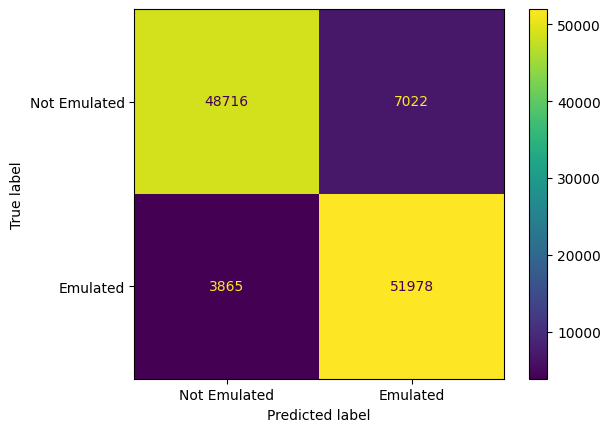

In [104]:
# Multi-Layered Perceptron Post-Run Statistics

accuracy = accuracy_score(mm_target_test, target_pred) * 100
accuracyArr[6] = accuracy
conMatrix = confusion_matrix(mm_target_test, target_pred)

print(f'Accuracy of model: {accuracy}%\n')
print(f'Classification Report:\n {classification_report(mm_target_test, target_pred)}')
ConfusionMatrixDisplay(conMatrix, display_labels=["Not Emulated", "Emulated"],).plot()
plt.show()

In [105]:
#Bagging Classifier

bgc=BaggingClassifier()
bgc.fit(minmax_train, mm_target_train)  
target_pred = bgc.predict(minmax_test)

Accuracy of model: 0.9517928679613913%

Classification Report:
               precision    recall  f1-score   support

       False       0.96      0.94      0.95     55738
        True       0.95      0.96      0.95     55843

    accuracy                           0.95    111581
   macro avg       0.95      0.95      0.95    111581
weighted avg       0.95      0.95      0.95    111581



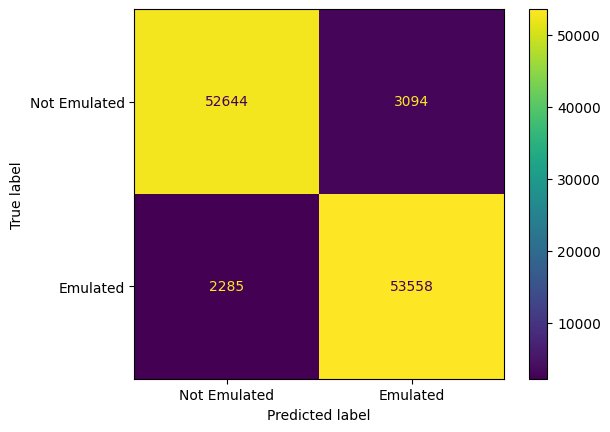

In [106]:
#Bagging Classifier Statistics

accuracy = accuracy_score(mm_target_test,target_pred) * 100
accuracyArr[7] = accuracy
conMatrix = confusion_matrix(mm_target_test, target_pred)

print(f'Accuracy of model: {accuracy}%\n')
print(f'Classification Report:\n {classification_report(mm_target_test, target_pred)}')
ConfusionMatrixDisplay(conMatrix, display_labels=["Not Emulated", "Emulated"],).plot()

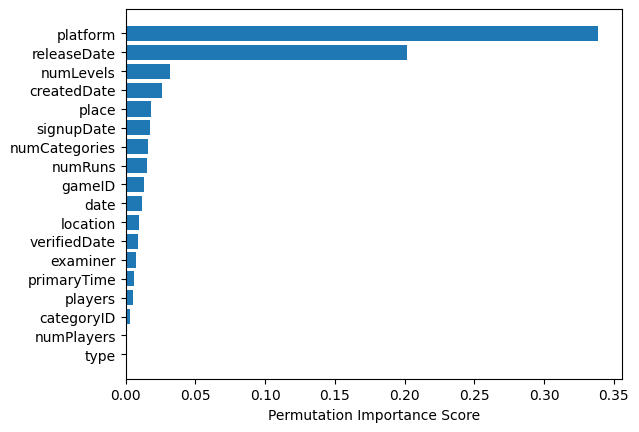

In [107]:
importance = skli.permutation_importance(bgc, minmax_test, mm_target_test, n_repeats=30, random_state=rdm_seed)
sorted_importances = importance.importances_mean.argsort()
plt.barh(minmax_train.columns[sorted_importances], importance.importances_mean[sorted_importances])
plt.xlabel("Permutation Importance Score")
plt.show()

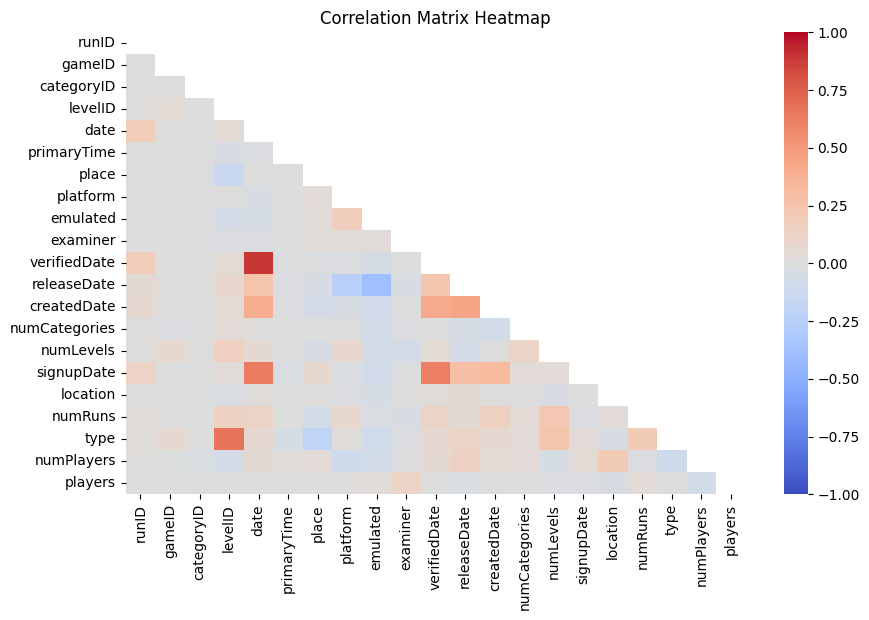

In [108]:
corr_matrix = data_frame.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) 
plt.figure(figsize=(10, 6)) 
heatmap = sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, cmap='coolwarm')
heatmap.set_title('Correlation Matrix Heatmap')
plt.show()

[88.53478638836361, 68.31270556815228, 95.54404423692205, 78.66841128866025, 93.09380629318612, 86.28261083876288, 90.2429625115387, 0.9517928679613913]


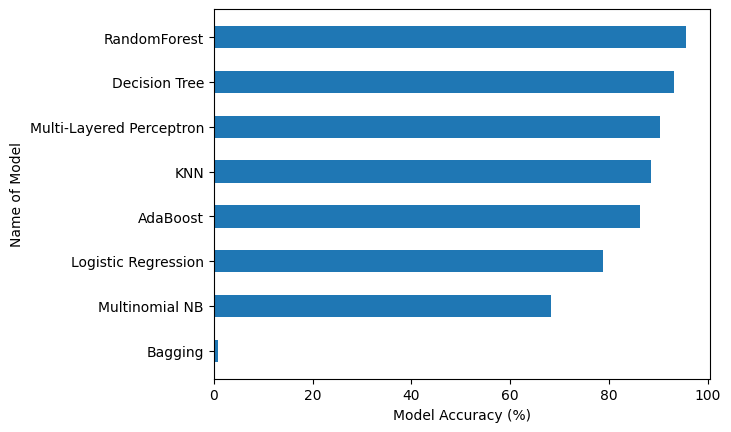

In [115]:
print(accuracyArr)
sorted_accuracies = np.array(accuracyArr).argsort()
plt.barh(np.array(modelNames)[sorted_accuracies], np.array(accuracyArr)[sorted_accuracies], height=0.5)
plt.xlabel("Model Accuracy (%)")
plt.ylabel("Name of Model")
plt.show()